# Voronoi Maps: Public Libraries

In [80]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl

%matplotlib inline


For this exercise we are going to use [smopy](https://github.com/rossant/smopy), a cool Python module that allow us to retrieve OpenStreetMap image maps from geographical coordinates.
Essentially, we need to define a box in geographical coordinates (latitude/longitude) and a zoom level. Smopy returns an OpenStreetMap tile image!


In [32]:
import smopy
print('Working on smopy', smopy.__version__)

Working on smopy 0.0.6


We are also going to use `scipy.spatial` to compute Voronoi diagrams, a partitioning of a plane into regions based on distance to points in a specific subset of the plane. Important to note, `scipy.spatial.Voronoi` uses the [Qhull](http://www.qhull.org/) library. 

Then, import the module:


In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d


Let's start by importing the data file, csv format. 

The csv file contains: name of library, postal code, square_feet, phone_nmber, business hours (monday to sunday), and adress, which includes GPS coordinates.


In [10]:
df = pd.read_csv('Calgary_Public_Library_Locations_and_Hours.csv')
print(df.head())

                        Library Postal_Code  Square_Feet  Phone_Number  \
0  W.R. Castell Central Library     T2G 2M2       177532  403-260-2600   
1     Alexander Calhoun Library     T2T 3V8         9256  403-260-2600   
2               Bowness Library     T3B 0H3         7800  403-260-2600   
3            Fish Creek Library     T2J 6S1        47074  403-260-2600   
4           Forest Lawn Library     T2A 4M1        16977  403-260-2600   

  Monday_Open Monday_Close Tuesday_Open Tuesday_Close Wednesday_Open  \
0        9:00        20:00         9:00         20:00           9:00   
1       10:00        21:00        10:00         21:00          10:00   
2       13:00        20:00        10:00         20:00          10:00   
3        9:00        21:00         9:00         21:00           9:00   
4       10:00        21:00        10:00         21:00          10:00   

  Wednesday_Close Thursday_Open Thursday_Close Friday_Open Friday_Close  \
0           20:00          9:00          20:00 


We can select a column of interest. For instance, to select the postal code, in column 2 `postal_code = df[df.columns[1:]]`

Or to select the library names, `library_names = df[ df.columns[0] ]`


In [34]:
postal_code = df[df.columns[1:]]
print(postal_code.head())

library_names = df[ df.columns[0] ]
print(library_names.head())

  Postal_Code  Square_Feet  Phone_Number Monday_Open Monday_Close  \
0     T2G 2M2       177532  403-260-2600        9:00        20:00   
1     T2T 3V8         9256  403-260-2600       10:00        21:00   
2     T3B 0H3         7800  403-260-2600       13:00        20:00   
3     T2J 6S1        47074  403-260-2600        9:00        21:00   
4     T2A 4M1        16977  403-260-2600       10:00        21:00   

  Tuesday_Open Tuesday_Close Wednesday_Open Wednesday_Close Thursday_Open  \
0         9:00         20:00           9:00           20:00          9:00   
1        10:00         21:00          10:00           21:00         10:00   
2        10:00         20:00          10:00           20:00         10:00   
3         9:00         21:00           9:00           21:00          9:00   
4        10:00         21:00          10:00           21:00         10:00   

  Thursday_Close Friday_Open Friday_Close Saturday_Open Saturday_Close  \
0          20:00        9:00        17:00       

Given that smopy requires the box with geographic coordinates, we need to extract the last column of the data framne. Then, we take latitud and longitud of each location (index). In pandas, extracting columns is actually very easy: just by using `df.columns[ ]`



In [73]:
#Define location by latitud and longitud
loc_ = df[ df.columns[-2]]
print(loc_)

address = df.Address.str.split('\n+\(|\)')

for index in range(len(address)):
    loc.append(address[index][1].split(','))

lat, lon, new_loc = [], [], []

for i in loc:
    lat.append(float(i[0]))
    lon.append(float(i[1]))
    new_loc.append( (float(i[0]) ,float(i[1]) ) )


0     (51.0470276, -114.0578995)
1     (51.0255318, -114.0947876)
2     (51.0872841, -114.1830978)
3     (50.9516296, -114.0603409)
4      (51.045105, -113.9652023)
5     (50.9835968, -114.0141449)
6     (51.0652428, -114.1038132)
7     (51.0412674, -114.0683823)
8     (51.0960922, -114.1391296)
9      (50.8986015, -114.062851)
10    (51.0181122, -114.1756439)
11     (50.963623, -114.0860367)
12    (51.1121979, -114.0633087)
13    (51.0753708, -113.9525833)
14    (51.1295815, -114.1926956)
15     (51.159462, -114.0675659)
16    (51.1196709, -113.9485092)
17     (51.0404778, -114.138237)
Name: Location, dtype: object



Now we can define the box of geographic coordinates by `[min_latitud, min_longitud, max_latitud, max_longitud]` extracted from the location of public libraries in Calgary.


In [64]:
box = [min(lat), min(lon), max(lat), max(lon)]
print(box)

[50.8986015, -114.1926956, 51.159462, -113.9485092]



Given the boundaries, now we use smopy to visualize the map of Calgary:


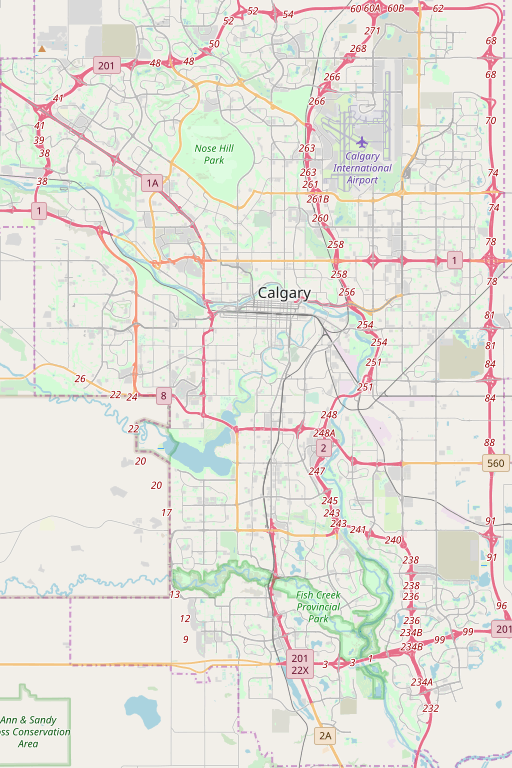

In [74]:
m = smopy.Map(box, z=11) 
m.show_ipython()

Given the points defined by `(lat, lon)` for each library, we create the Voronoi diagram for the set of point stored in `new_loc`:


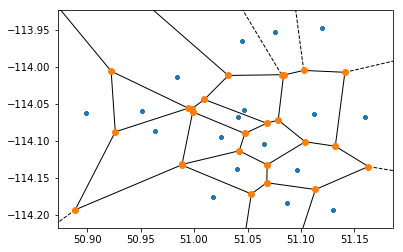

In [81]:
vor = Voronoi(new_loc)
print(vor)

voronoi_plot_2d(vor)
plt.show()

However, we still need to fit our Voronoi diagram to the map retrieved given `box = [min(lat), min(lon), max(lat), max(lon)]`

In [62]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [68]:
regions, vertices = voronoi_finite_polygons_2d(vor)

KeyError: 4

In [58]:
faces = [m.to_pixels(vertices[region]) for region in regions]

NameError: name 'regions' is not defined

In [ ]:
cmap = plt.cm.Pastel1
cuadrants = 7


colors_by_face = cmap( np.linspace(0, 1, cuadrants))[:,3]

colors = .25 * np.ones((len(address)+1, 3))

NameError: name 'faces' is not defined

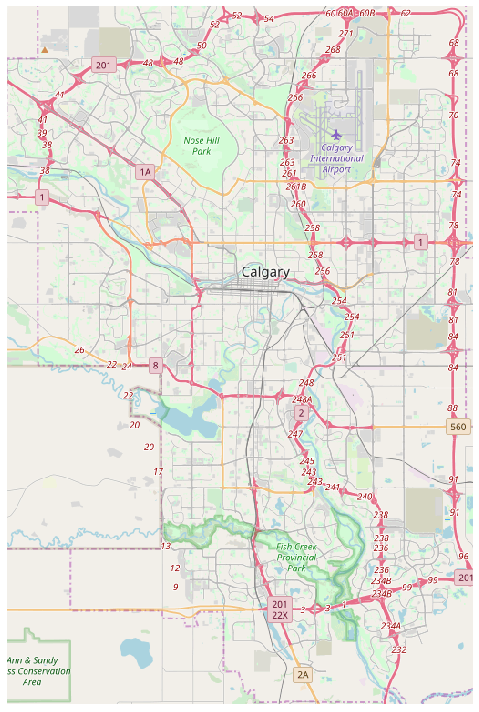

In [29]:
ax = m.show_mpl(figsize=(10,10))
ax.add_collection( mpl.collections.PolyCollection(faces, edgecolors='k', alpha=0.25, linewidth=2.5))